# Aplicando modelagem de assuntos ao DHBB
Neste capítulo vamos explorar ferramentas de modelagem de assuntos e explorar aplicações ao DHBB. Como sempre, começamos com alguns imports familiares.

In [1]:
import os, glob, pickle
import spacy
from spacy import displacy
from sqlalchemy import create_engine
from dhbbmining import *
import ipywidgets as widgets
from tqdm import tqdm

2022-11-16 13:04:21.322712: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 13:04:21.514319: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 13:04:22.188692: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-16 13:04:22.188811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

Vamos também carregar o modelo de NLP para a língua portuguesa do Spacy:

In [2]:
!python -m spacy download pt_core_news_sm

fish: Unknown command: python
fish: 
python -m spacy download pt_core_news_sm
^


In [3]:
nlp = spacy.load("pt_core_news_sm")

Agora faremos alguns imports novos, particularmente da biblioteca [Gensim](https://radimrehurek.com/gensim), que nos oferece as ferramentas que necessitamos para modelagem de assuntos.

In [4]:
from string import punctuation
from gensim.test.utils import datapath
from gensim import utils
from gensim.models import Word2Vec, word2vec

Para minimizar o uso de memória, vamos construir uma classe para representar o nosso corpus como um iterador, operando diretamente do banco de dados. Desta forma, ao fazer nossas análises, podemos carregar um documento por vez para alimentar os modelos, sem a necessidade de manter todo o corpus na memória, economizando memória RAM.

In [5]:
eng = create_engine("sqlite:///minha_tabela.sqlite")

class DHBBCorpus:
    def __init__(self, ndocs=10000):
        self.ndocs = min(7687,ndocs)
        self.counter = 1
    def __iter__(self):
        with eng.connect() as con:
            res = con.execute(f'select corpo from resultados limit {self.ndocs};')
            for doc in res:
                d = self.pre_process(doc[0])
                if self.counter%10 == 0:
                    print (f"Verbete {self.counter} de {6*self.ndocs}\r", end='')
                for s in d:
                    yield s
                self.counter += 1
    def pre_process(self, doc):
        n = nlp(doc, disable=['tagger', 'ner','entity-linker', 'textcat','entity-ruler','merge-noun-chunks','merge-entities','merge-subtokens'])
        results = []
        for sentence in n.sents:
            s = sentence.text.split()
            if not s:
                continue
            results.append([token.strip().strip(punctuation) for token in s if token.strip().strip(punctuation)])
        return results
        

Abaixo um pequeno exemplo de como a classe `DHBBCorpus` funciona:

In [6]:
DC = DHBBCorpus(5)
for f in DC:
    pass
    print(f)
    break
    

['«José', 'Machado', 'Coelho', 'de', 'Castro»', 'nasceu', 'em', 'Lorena', 'SP']


In [7]:
Word2Vec?

Init signature:
Word2Vec(
    sentences=None,
    corpus_file=None,
    vector_size=100,
    alpha=0.025,
    window=5,
    min_count=5,
    max_vocab_size=None,
    sample=0.001,
    seed=1,
    workers=3,
    min_alpha=0.0001,
    sg=0,
    hs=0,
    negative=5,
    ns_exponent=0.75,
    cbow_mean=1,
    hashfxn=<built-in function hash>,
    epochs=5,
    null_word=0,
    trim_rule=None,
    sorted_vocab=1,
    batch_words=10000,
    compute_loss=False,
    callbacks=(),
    comment=None,
    max_final_vocab=None,
    shrink_windows=True,
)
Docstring:     
Serialize/deserialize objects from disk, by equipping them with the `save()` / `load()` methods.

Warnings
--------
This uses pickle internally (among other techniques), so objects must not contain unpicklable attributes
such as lambda functions etc.
Init docstring:
Train, use and evaluate neural networks described in https://code.google.com/p/word2vec/.

Once you're finished training a model (=no more updates, only querying)
store

## Word2vec 
Vamos começar pelo treinamento de um modelo word2vec. Este modelo itera 6 vezes sobre o corpus logo, devemos ver o contador atingir 46122. Estas repetições são necessárias para permitir a 

In [9]:
if os.path.exists('dhbb.w2v'):
    model = Word2Vec.load('dhbb.w2v')
else:
    DC = DHBBCorpus()
    model = Word2Vec(sentences=DC, workers=32)
    model.save('dhbb.w2v')

### Explorando o modelo

In [10]:
for i, word in enumerate(model.wv.index_to_key):
    if i == 10:
        break
    print(word)

de
a
do
e
da
o
em
que
no
na


In [11]:
model.wv['Deputado'] - model.wv['deputado']

array([-3.0996436e-01, -1.5877485e-02, -1.5051268e-02, -2.4578695e+00,
       -1.8383999e+00,  1.3759757e+00, -2.1121233e+00, -2.2401438e+00,
       -2.4972947e+00,  4.4667423e-01, -3.8132471e-01, -1.6456211e+00,
        1.5593696e-01, -7.2023493e-01,  1.7426707e+00,  2.4558010e+00,
        6.6785970e+00, -7.7980298e-01,  1.9919223e+00, -1.4275929e+00,
       -3.4091330e+00,  1.0715044e+00, -1.4560964e+00,  2.2716761e-01,
        2.4683971e+00,  8.9598668e-01, -1.0678246e+00,  1.7736235e+00,
        3.2234378e+00,  3.1494856e+00, -1.4241810e+00, -3.1679513e+00,
       -7.6618582e-01, -3.7193185e-01, -1.8184069e-01, -9.7479165e-01,
       -1.7631760e+00,  5.5295229e-03,  2.7403109e+00, -1.1091195e+00,
        2.6276081e+00, -8.3860022e-01,  2.6800597e+00, -3.9960945e+00,
        1.2816764e+00,  2.6876445e+00,  2.5220795e+00,  1.2691977e+00,
        3.8920553e+00,  2.6818435e+00, -6.5869278e-01,  7.5531489e-01,
       -1.8512478e+00,  5.8441418e-01, -2.6765628e+00,  2.8536856e+00,
      

In [12]:
len(model.wv.index_to_key)

38762

In [13]:
model.wv.most_similar(positive=['direita'],negative=['Comunista'], topn=20)

[('progressistas', 0.5529391169548035),
 ('segmentos', 0.5388556718826294),
 ('conservadores', 0.5193644165992737),
 ('antigetulistas', 0.515348494052887),
 ('setores', 0.5146178603172302),
 ('nacionalistas', 0.5058426856994629),
 ('esquerda', 0.5054914951324463),
 ('oposição', 0.4820389747619629),
 ('extrema', 0.47334492206573486),
 ('oposicionistas', 0.4595625698566437),
 ('adeptos', 0.44704267382621765),
 ('udenistas', 0.44662249088287354),
 ('centro-esquerda', 0.44410112500190735),
 ('radicais', 0.43817466497421265),
 ('pessedistas', 0.4352889060974121),
 ('moderados', 0.4338815212249756),
 ('liberais', 0.43283340334892273),
 ('jovens', 0.43128761649131775),
 ('grupos', 0.42958810925483704),
 ('ambientalistas', 0.42890769243240356)]

In [14]:
model.corpus_total_words

8713256

In [15]:
model.vocabulary?

Object `model.vocabulary` not found.


### Visualizando os vetores de palavras

In [16]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    i = 0
    for word in model.wv.index_to_key:
        vectors.append(model.wv[word])
        labels.append(word)
        i+=1
        if i>200:
            break

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')

/home/fccoelho/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/fccoelho/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


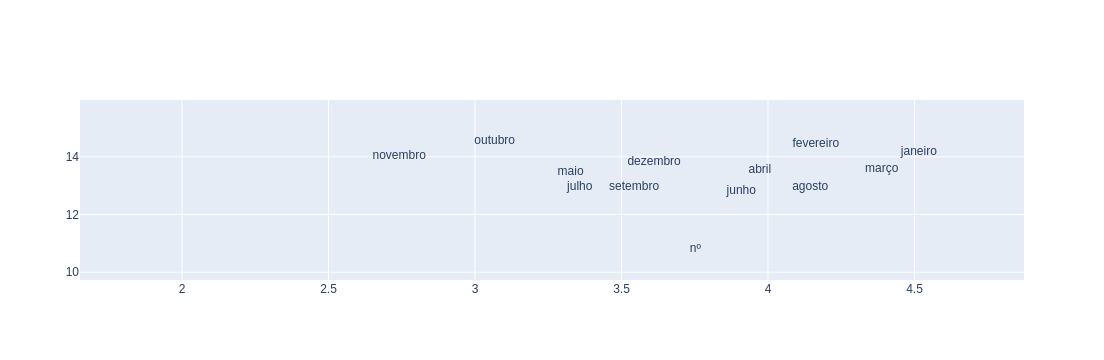

In [17]:
plot_with_plotly(x_vals, y_vals, labels)

In [18]:
model.wv.most_similar(positive=['deputado', 'mulher'], negative=['homem'])

[('deputada', 0.707239031791687),
 ('senadora', 0.6504750847816467),
 ('governadora', 0.5311956405639648),
 ('vaga', 0.5001533031463623),
 ('senador', 0.49622222781181335),
 ('bancada', 0.49382296204566956),
 ('prefeita', 0.4898069202899933),
 ('esposa', 0.4874173700809479),
 ('vereadora', 0.477497398853302),
 ('ex-deputado', 0.4704161286354065)]

In [19]:
model.wv.most_similar(positive=['Sergipe', 'Salvador'], negative=['Bahia'])

[('Aracaju', 0.7568933963775635),
 ('Fortaleza', 0.7413235306739807),
 ('Maceió', 0.7330026030540466),
 ('Manaus', 0.729759693145752),
 ('Curitiba', 0.722693920135498),
 ('Teresina', 0.7146587371826172),
 ('Cuiabá', 0.7008069753646851),
 ('Dourados', 0.6986944675445557),
 ('Belém', 0.6970897912979126),
 ('Goiânia', 0.6968613862991333)]

In [20]:
model.wv.most_similar(positive=['congressista', 'política'], negative=['homem'])

[('independente”', 0.5179454684257507),
 ('Iniciando-se', 0.47886374592781067),
 ('turística', 0.477364718914032),
 ('duradouras', 0.4718947410583496),
 ('“política', 0.4573584198951721),
 ('induzida', 0.45302215218544006),
 ('marxista”', 0.4503825306892395),
 ('conflituosas', 0.45008936524391174),
 ('pragmática', 0.4451919496059418),
 ('stalinista', 0.4449922740459442)]

In [21]:
model.wv['congressista'] + model.wv['política']-model.wv['homem']

array([-1.1804812 ,  0.17904007,  2.7701726 ,  2.2788234 , -2.3939579 ,
       -1.6261489 ,  3.037264  , -1.5370936 ,  0.1686287 ,  1.7679174 ,
       -0.6206008 , -1.4379971 ,  0.9625195 ,  5.3786445 , -1.5540149 ,
       -0.00777411, -1.401691  , -4.2874527 , -0.82898766,  1.8527349 ,
        1.1073897 ,  0.4124229 , -1.7202759 , -1.9285159 ,  0.22249055,
       -0.1637733 ,  0.3505941 , -1.6477919 ,  3.5996528 , -1.884695  ,
        0.70941716,  2.4855223 ,  0.19784053,  1.0554858 , -2.0812526 ,
        0.25975254,  1.0439771 ,  0.40970242,  0.78404856, -2.2612848 ,
        1.7169695 ,  0.73526394,  1.4105549 ,  4.066178  , -0.40555423,
        1.8521545 ,  3.7054353 ,  1.3822607 , -4.056506  ,  1.9932911 ,
        0.89136565, -2.6281335 ,  3.6849546 ,  3.6759586 , -0.3893448 ,
       -0.93963474,  3.059989  ,  0.07065499, -0.69516784, -1.2888556 ,
        0.92977023, -1.6649121 ,  2.6862006 , -2.4784298 ,  1.8600826 ,
        0.779212  ,  2.1920981 , -1.9809456 , -2.688896  ,  0.60

## Word Movers Distance
Este método permite que calculemos a distância entre dois documentos mesmo que estes não contenham palavras em comum. Este método foi proposto no artigo ["From Word Embeddings To Document Distances"](http://jmlr.org/proceedings/papers/v37/kusnerb15.pdf).

In [ ]:
!pip install pyemd

In [23]:
DC = list(DHBBCorpus(5))
model.wv.wmdistance(document1=DC[1],document2=DC[2])

0.934275399671953

In [24]:
print(DC[1])
print(DC[2])

['Estudou', 'no', 'Ginásio', 'Diocesano', 'de', 'São', 'Paulo', 'e', 'bacharelou-se', 'em', '1910', 'pela', 'Faculdade', 'de', 'Ciências', 'Jurídicas', 'e', 'Sociais']
['Dedicando-se', 'à', 'advocacia', 'foi', 'promotor', 'público', 'em', 'Cunha', 'SP', 'e', 'depois', 'delegado', 'de', 'polícia', 'no', 'Rio', 'de', 'Janeiro', 'então', 'Distrito', 'Federal']


In [25]:
model.wv.wmdistance(document1=DC[1],document2='frequentou a escola religiosa em Niteroi e formou-se em 1935 pela UFF'.split())

0.8236512292091595